In [1]:
%%capture

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd

data_url = "./data/my_data.csv"
data = pd.read_csv(data_url)

data.head()

,department,telecommuting,has_company_logo,has_questions,employment_type,industry,function,fraudulent,Country,len_profile,len_description,requirement_is_existed
0,Marketing,0,1,0,Other,NaN,Marketing,0,US,885,905,True
1,etc,0,1,0,Full-time,Marketing and Advertising,Customer Service,0,NZ,1286,2077,True
2,etc,0,1,0,NaN,NaN,NaN,0,US,879,355,False
3,Sales,0,1,0,Full-time,Computer Software,Sales,0,US,614,2600,True
4,etc,0,1,1,Full-time,Hospital & Health Care,Health Care Provider,0,US,1628,1520,True


In [3]:
# data split train/valid/test
from sklearn.model_selection import train_test_split

target = 'fraudulent'

train, test = train_test_split(data, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((10728, 12), (3576, 12), (3576, 12))

In [4]:
features = data.columns.drop([target, "has_company_logo"]).tolist()

x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

In [5]:
# calculate ratio (target imbalance)
vc = y_train.value_counts().tolist()
vc

ratio = float(vc[0]/vc[1]) # sum(negative instances) / sum(positive instances)
ratio

19.670520231213874

In [6]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, Pipeline

pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(n_estimators=200, random_state=2, 
        n_jobs=-1, learning_rate=0.2, scale_pos_weight=ratio,
        use_label_encoder=False, eval_metric='error')) 
])

pipe.fit(x_train, y_train);

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = pipe.predict(x_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.9639261744966443
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3362
           1       0.75      0.60      0.67       214

    accuracy                           0.96      3576
   macro avg       0.86      0.79      0.82      3576
weighted avg       0.96      0.96      0.96      3576



/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [8]:
pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder',
                  OrdinalEncoder(cols=['department', 'employment_type',
                                       'industry', 'function', 'Country'],
                                 mapping=[{'col': 'department',
                                           'data_type': dtype('O'),
                                           'mapping': etc             1
 Sales           2
 Operations      3
 Marketing       4
 Product         5
 IT              6
 Engineering     7
 Design          8
 Technology      9
 Development    10
 Service        11
 NaN            -2
 dtype: int64},
                                          {'col': 'employment_type',
                                           'data_type': dtype('O'),
                                           'mapping'...
 Quality Assurance         24
 Business Development      25
 Project Management        26
 Advertising               27
 Production                28
 Science                   2

In [9]:
# Permutation(순열) Importance
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['xgb'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
x_val_transformed = pipe.named_steps['preprocessing'].transform(x_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(x_val_transformed, y_val);

feature_names = x_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Weight,Feature
0.0328 ± 0.0042,len_profile
0.0100 ± 0.0049,len_description
0.0079 ± 0.0026,industry
0.0043 ± 0.0026,employment_type
0.0042 ± 0.0056,Country
0.0023 ± 0.0014,requirement_is_existed
0.0013 ± 0.0022,department
0.0008 ± 0.0018,has_questions
0.0006 ± 0.0026,function
0.0002 ± 0.0003,telecommuting


/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


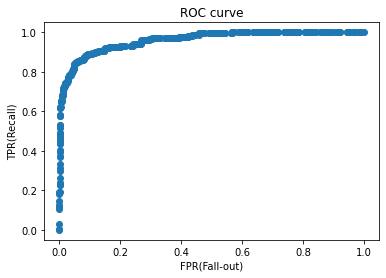

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# ROC Curve, AUC Score
from sklearn.metrics import roc_curve

y_pred_proba = pipe.predict_proba(x_val)[:, 1]
# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [11]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.960836154430212

In [12]:
# 과적합된 상태
from sklearn.metrics import f1_score

y_train_pred = pipe.predict(x_train)
y_val_pred = pipe.predict(x_val)

print('훈련 f1 score: ', f1_score(y_train, y_train_pred, average='binary'))
print('검증 f1 score: ', f1_score(y_val, y_val_pred, average='binary'))

훈련 f1 score:  0.9161518093556928
검증 f1 score:  0.6666666666666666


/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/a

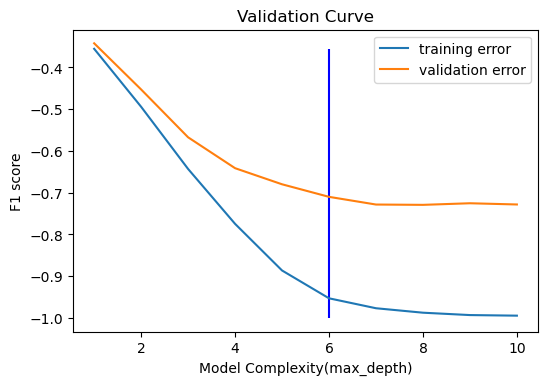

In [40]:
# validation curve
import numpy as np
from sklearn.model_selection import validation_curve

max_depth = range(1, len(x_train.columns)+1)

ts, vs = validation_curve(
    pipe, x_train, y_train
    , param_name='xgb__max_depth'
    , param_range=max_depth, scoring='f1'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)

fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(max_depth, train_scores_mean, label='training error')

# 검증세트 검증곡선
ax.plot(max_depth, validation_scores_mean, label='validation error')

# 이상적인 max_depth
ax.vlines(6, -1, train_scores_mean.max(), color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='F1 score')
ax.legend()
fig.dpi = 100

In [50]:
# tune Hyperparameter

from sklearn.model_selection import RandomizedSearchCV

dists = {
    'xgb__n_estimators': range(50, 210, 10),
    'xgb__max_depth': range(1, len(x_train.columns)+1), 
    'xgb__min_child_weight': range(2, 6),
    'xgb__scale_pos_weight': [20, 30, 50, 99]
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(x_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/anaconda3/envs/py_ML/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/mnt/d/a

최적 하이퍼파라미터:  {'xgb__scale_pos_weight': 20, 'xgb__n_estimators': 160, 'xgb__min_child_weight': 3, 'xgb__max_depth': 8}


In [51]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,19,9,38,32,47,28,34,42,20,48,...,3,45,10,27,17,39,40,35,26,49
mean_fit_time,33.522361,67.232721,46.418795,78.638124,43.230412,48.660605,39.342198,30.405021,67.200373,37.252614,...,12.667081,11.859579,9.288809,14.85732,11.5848,7.175693,5.77432,7.389866,12.199775,5.674643
std_fit_time,8.190764,21.23805,7.814758,15.598352,8.964095,15.096451,9.637439,9.600029,8.515565,4.199509,...,2.386633,4.285726,2.593888,3.340386,2.031544,1.939143,2.039552,2.243248,3.566167,1.493096
mean_score_time,0.377568,0.433929,0.354563,0.390164,0.286277,0.377856,0.367776,0.281335,0.551446,0.110366,...,0.329591,0.337045,0.332823,0.393458,0.343913,0.322979,0.304872,0.323005,0.302804,0.27541
std_score_time,0.067734,0.06816,0.087144,0.069966,0.068643,0.047631,0.103071,0.090843,0.093889,0.026636,...,0.067572,0.057649,0.077258,0.213636,0.062677,0.07099,0.098379,0.061867,0.023638,0.021629
param_xgb__scale_pos_weight,20,99,20,50,50,50,20,50,99,50,...,30,50,20,99,30,50,30,50,99,99
param_xgb__n_estimators,160,200,130,180,170,160,100,110,200,150,...,140,90,170,140,200,70,90,170,180,110
param_xgb__min_child_weight,3,3,2,2,2,3,3,3,2,4,...,5,2,5,3,5,3,4,4,2,5
param_xgb__max_depth,8,8,8,9,9,10,10,9,8,10,...,2,3,1,2,1,2,1,1,1,1
params,"{'xgb__scale_pos_weight': 20, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 99, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 20, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 20, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 99, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...",...,"{'xgb__scale_pos_weight': 30, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 20, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 99, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 30, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 30, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 50, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 99, 'xgb__n_estimato...","{'xgb__scale_pos_weight': 99, 'xgb__n_estimato..."
split0_test_score,0.783019,0.776256,0.759615,0.761905,0.771429,0.755981,0.754717,0.733032,0.752381,0.763636,...,0.396694,0.369352,0.338645,0.303406,0.307443,0.290801,0.290123,0.233216,0.183453,0.14967


In [52]:
# 위에서 찾은 최적 하이퍼파라미터를 적용한 모델 생성.  
pipe_cv = clf.best_estimator_

# 위 최적 모델에 훈련/검증 데이터 넣고 스코어 추출. 
y_val_pred = pipe_cv.predict(x_val)
y_train_pred = pipe_cv.predict(x_train)

print('훈련 f1 score: ', f1_score(y_train, y_train_pred, average='binary'))
print('검증 f1 score: ', f1_score(y_val, y_val_pred, average='binary'))

훈련 f1 score:  0.9243098842386465
검증 f1 score:  0.673740053050398


(<Figure size 8640x5472 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='len_profile'>})

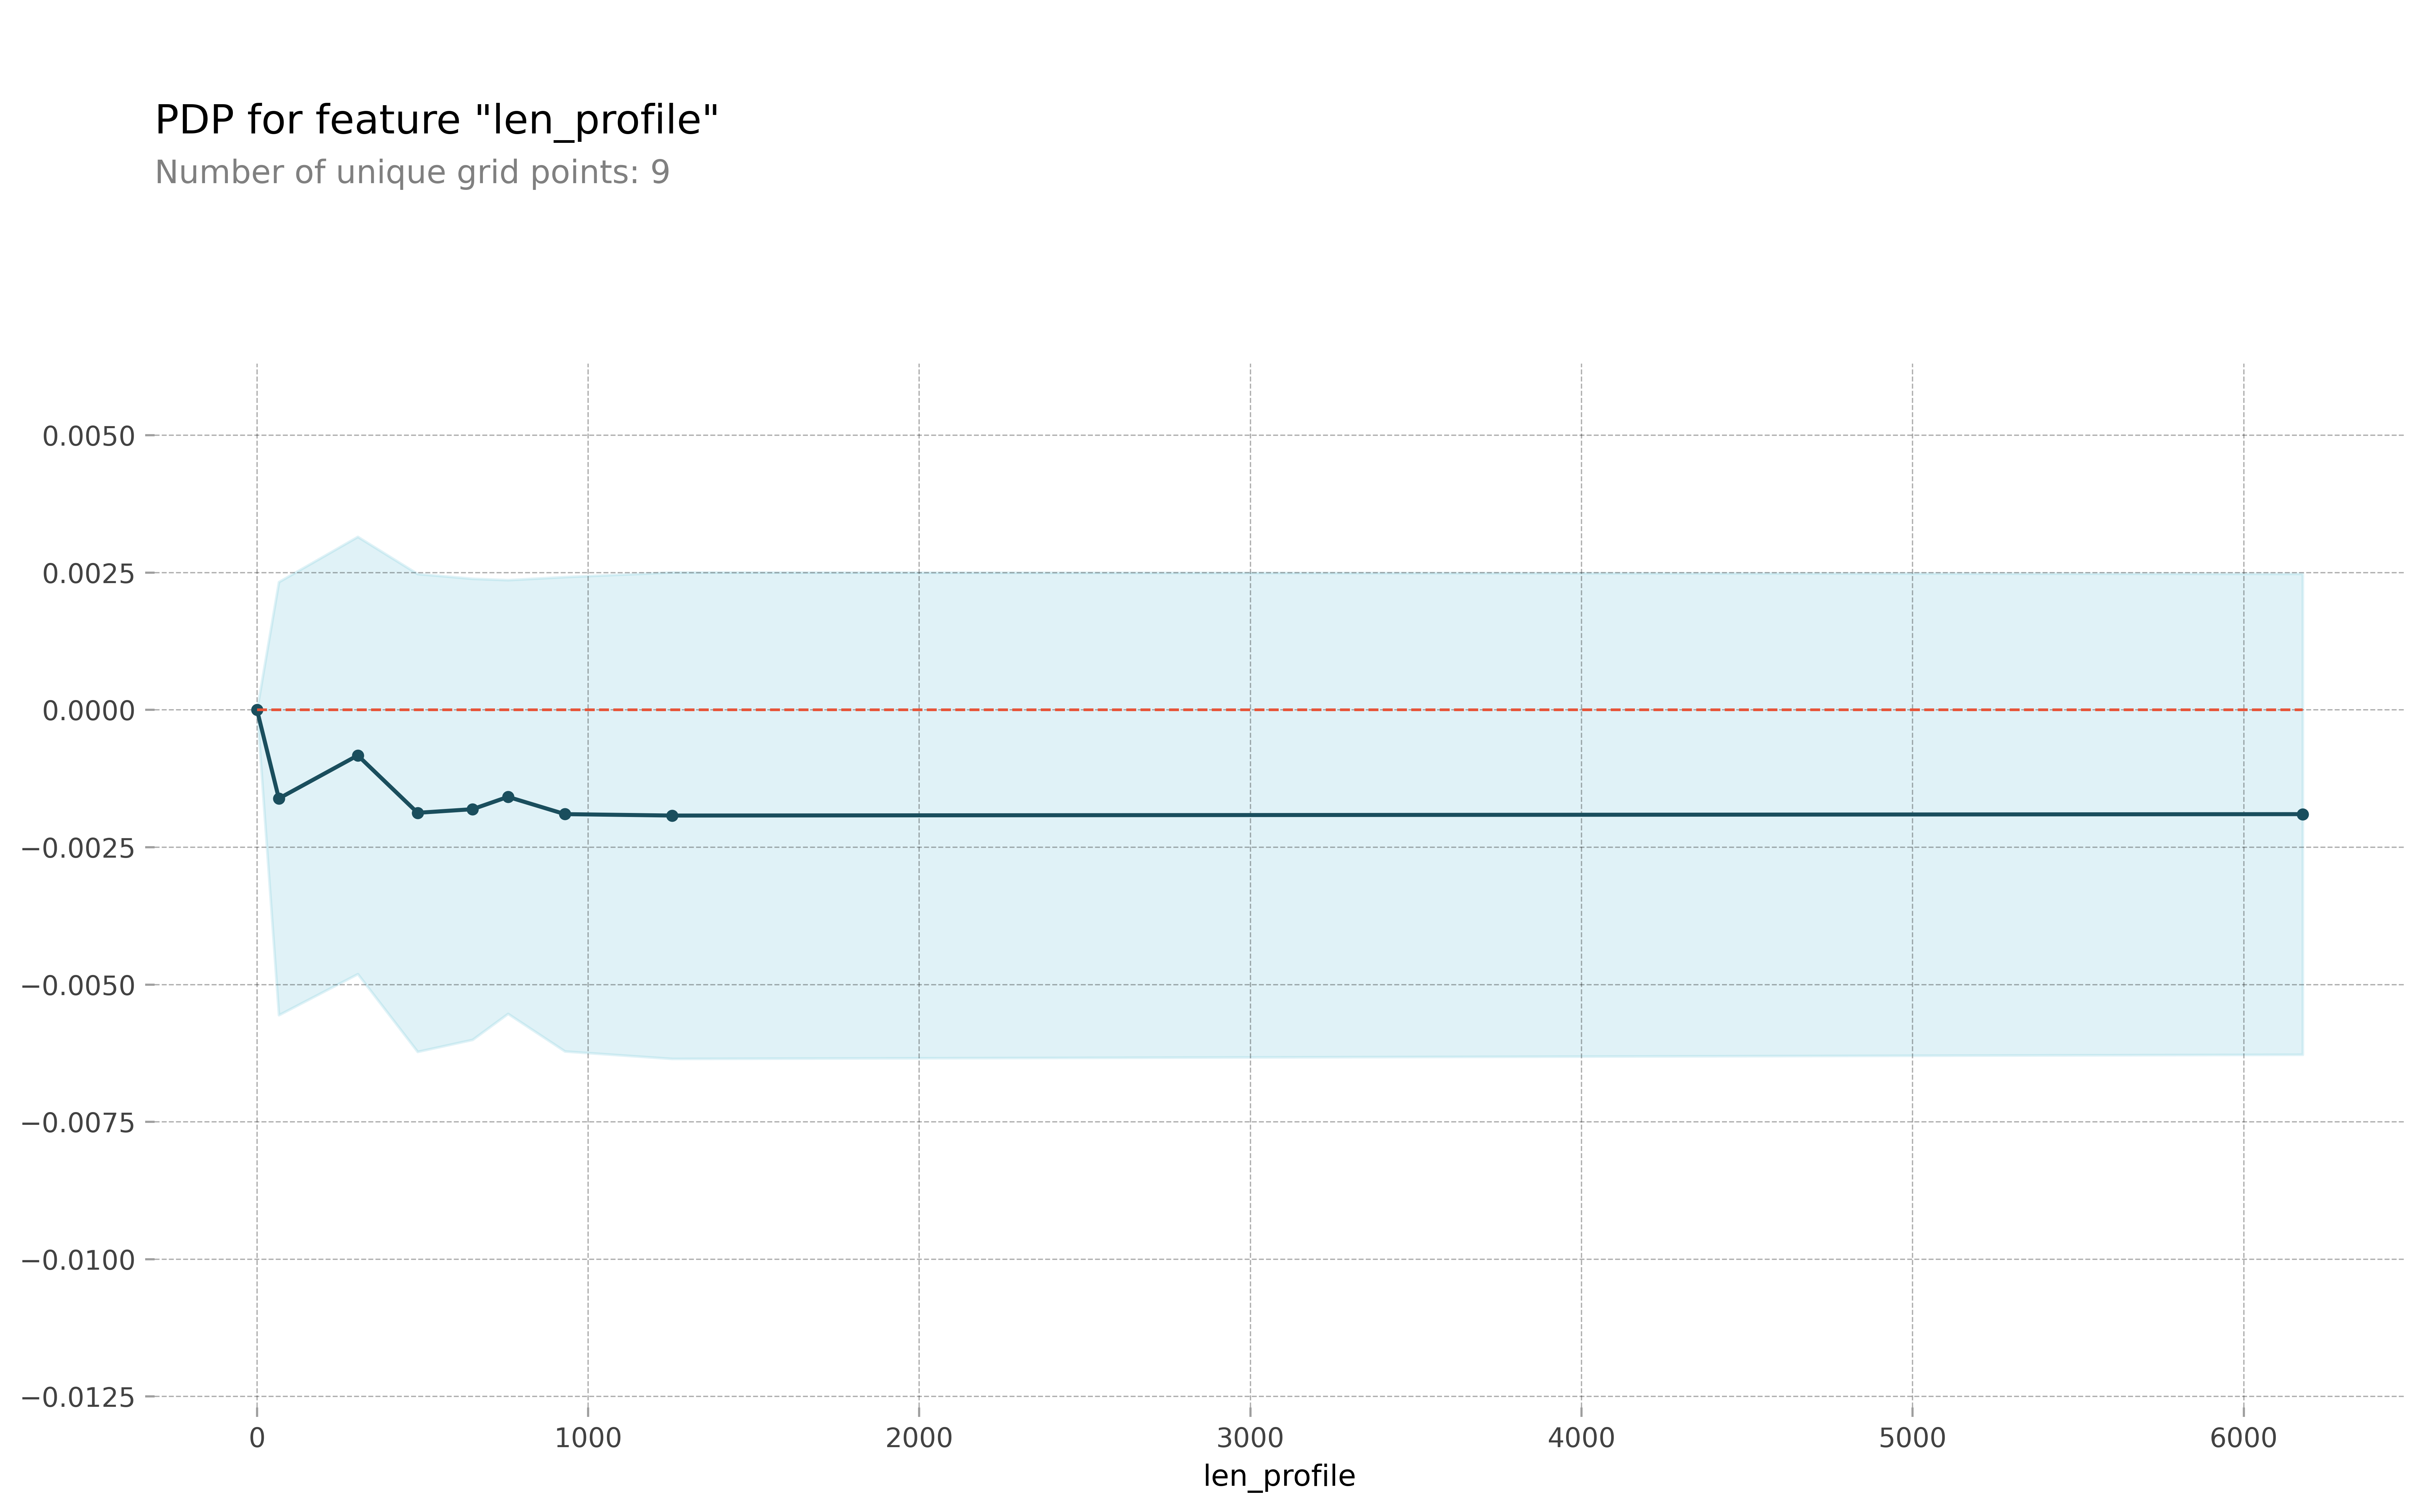

In [53]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
plt.rcParams['figure.dpi'] = 576
feature = 'len_profile'

preprocess = pipe.named_steps["preprocessing"]
x_train_encoded = preprocess.named_steps["ordinalencoder"].fit_transform(x_train)
x_val_encoded = preprocess.named_steps["ordinalencoder"].transform(x_val)

# draw pdp chart
isolated = pdp_isolate(
    model=pipe, 
    dataset=x_val_encoded, 
    model_features=x_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature)

In [54]:
pipe_cv.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder',
                  OrdinalEncoder(cols=['department', 'employment_type',
                                       'industry', 'function', 'Country'],
                                 mapping=[{'col': 'department',
                                           'data_type': dtype('O'),
                                           'mapping': etc             1
 Sales           2
 Operations      3
 Marketing       4
 Product         5
 IT              6
 Engineering     7
 Design          8
 Technology      9
 Development    10
 Service        11
 NaN            -2
 dtype: int64},
                                          {'col': 'employment_type',
                                           'data_type': dtype('O'),
                                           'mapping'...
 Quality Assurance         24
 Business Development      25
 Project Management        26
 Advertising               27
 Production                28
 Science                   2

In [55]:
import shap

x_test_encoded = preprocess.named_steps["ordinalencoder"].transform(x_test)
explainer = shap.TreeExplainer(pipe_cv.named_steps["xgb"])

#force plot
shap.initjs()
shap_values = explainer.shap_values(x_test_encoded.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, x_test_encoded.iloc[:100])

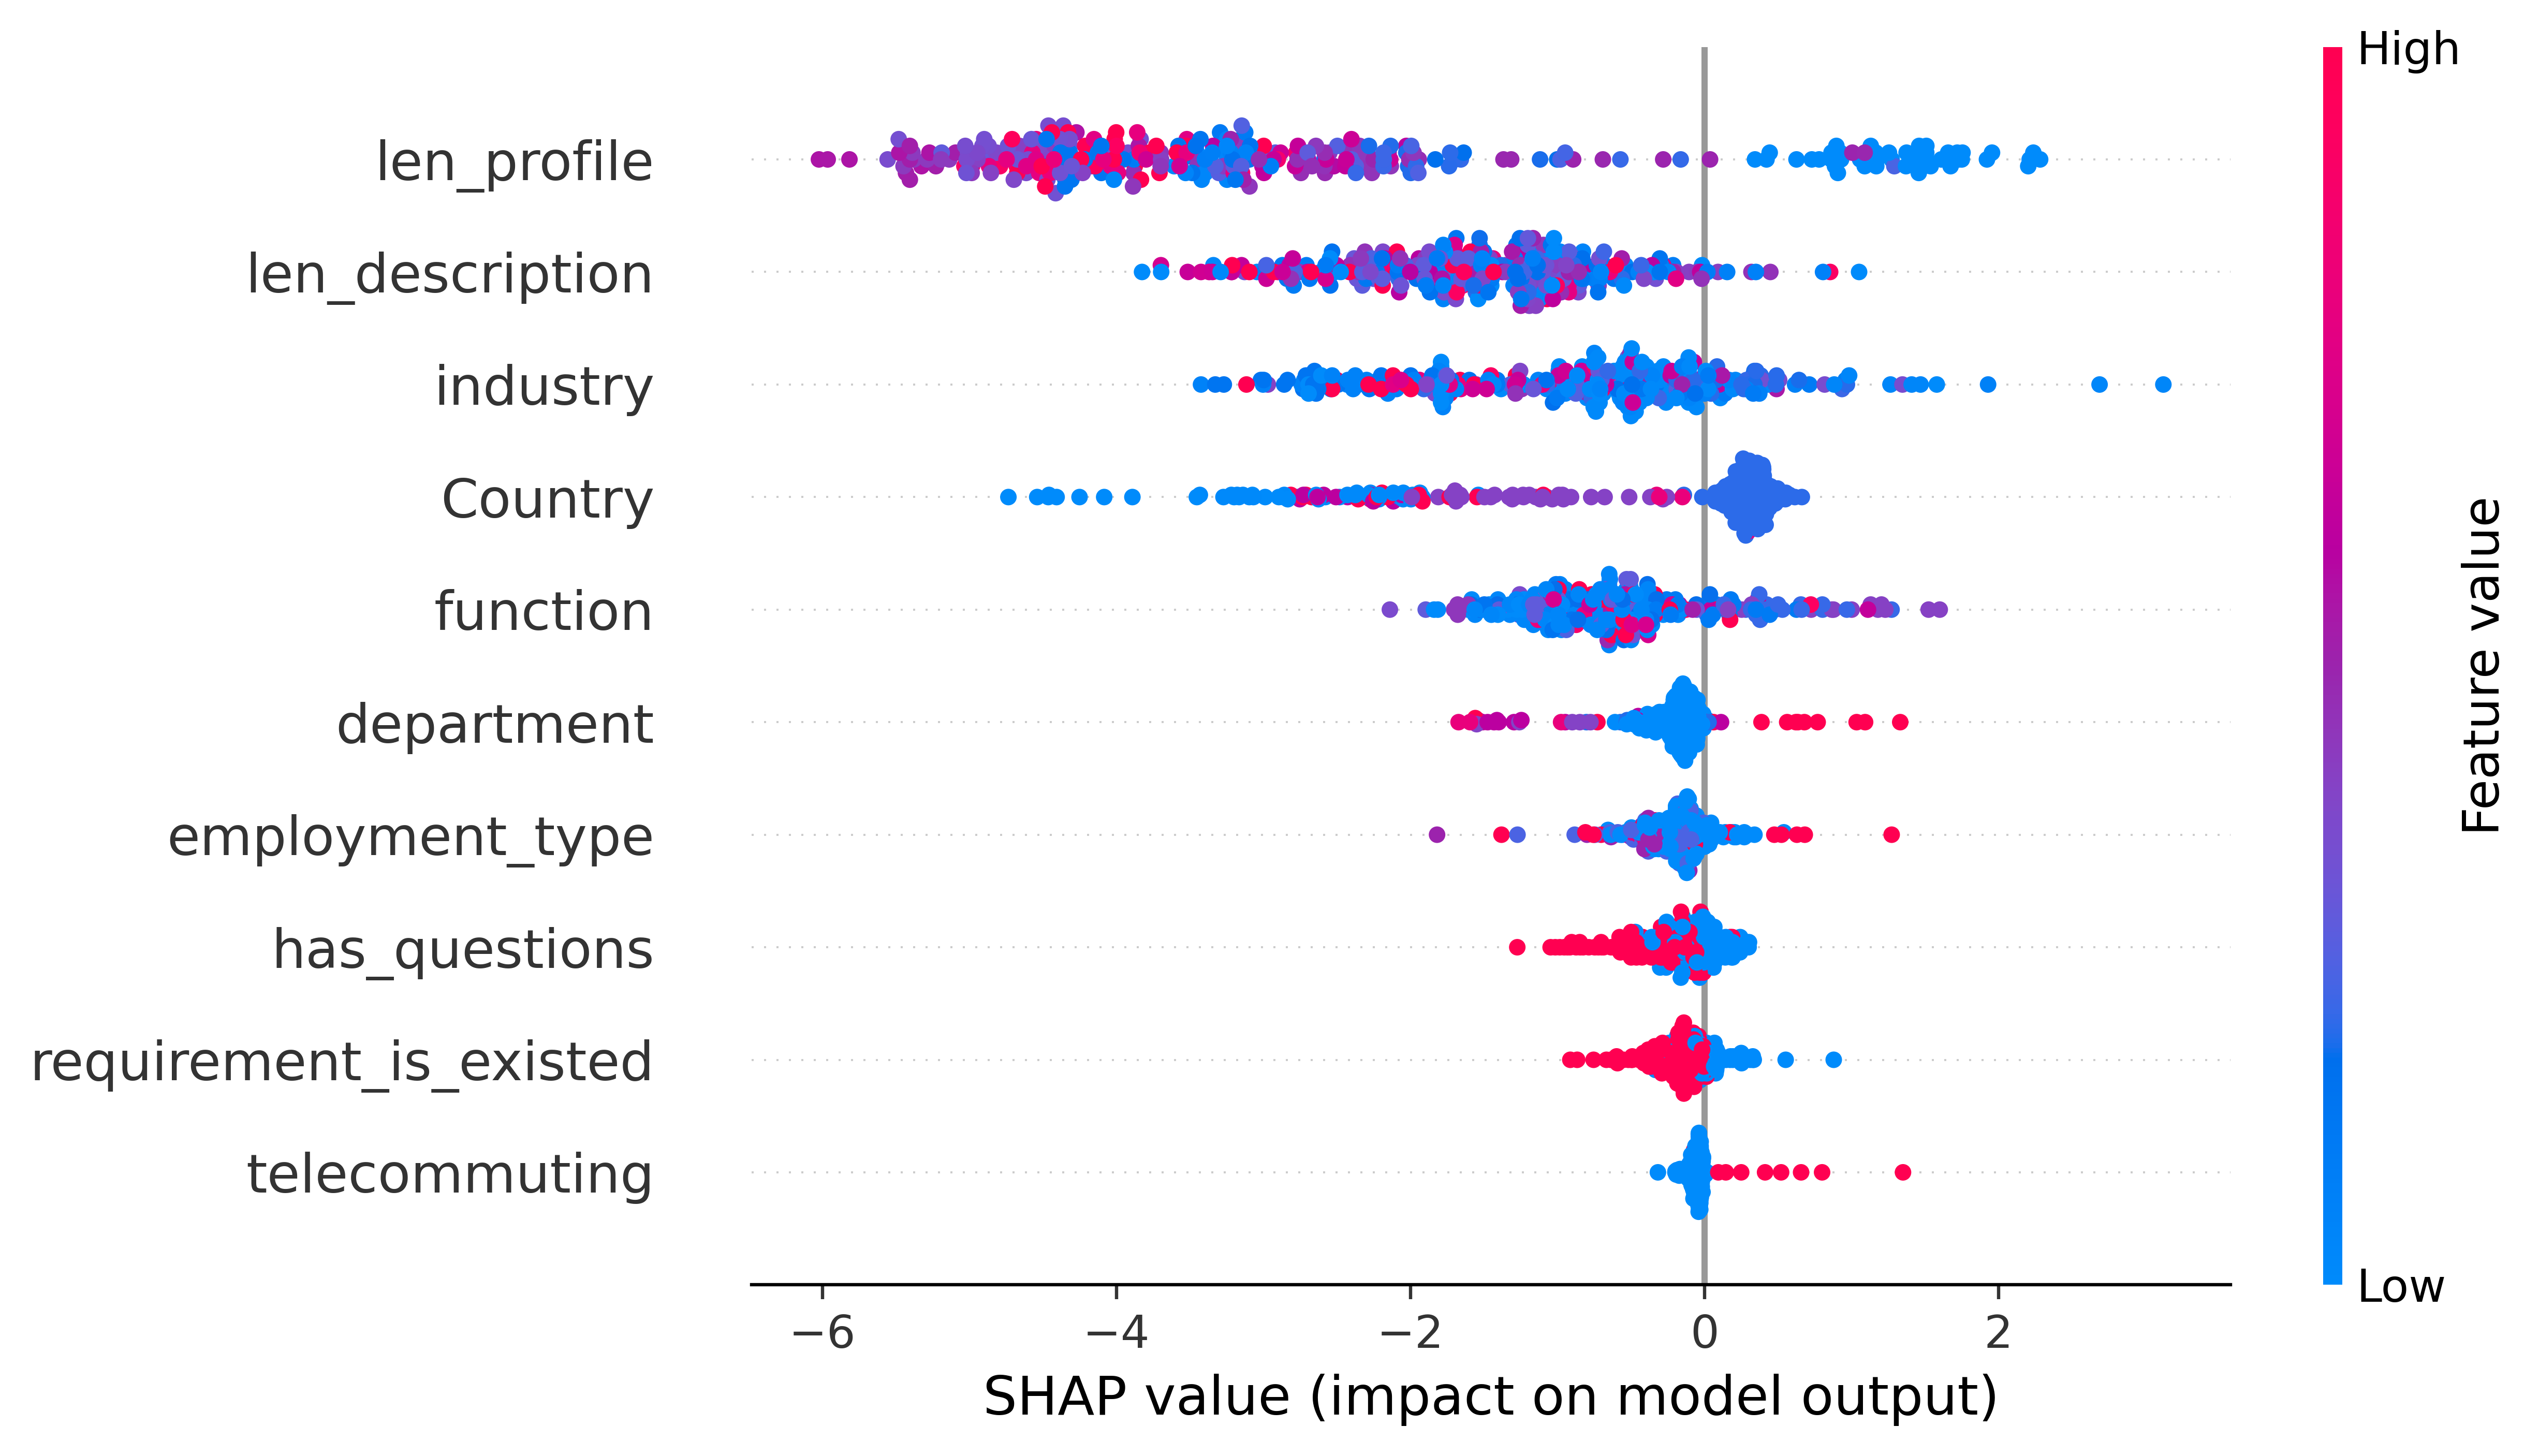

In [56]:
# summary_plot

shap_values = explainer.shap_values(x_test_encoded.iloc[:300])
shap.summary_plot(shap_values, x_test_encoded.iloc[:300])

In [58]:
y_test = test[target]

print('test score :', pipe.score(x_test, y_test))
print('test score(After CV) :', pipe_cv.score(x_test, y_test))

print(classification_report(y_test, pipe.predict(x_test)))
print(classification_report(y_test, pipe_cv.predict(x_test)))

test score : 0.9703579418344519
test score(After CV) : 0.970917225950783
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3402
           1       0.67      0.77      0.72       174

    accuracy                           0.97      3576
   macro avg       0.83      0.88      0.85      3576
weighted avg       0.97      0.97      0.97      3576

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3402
           1       0.68      0.76      0.72       174

    accuracy                           0.97      3576
   macro avg       0.83      0.87      0.85      3576
weighted avg       0.97      0.97      0.97      3576

